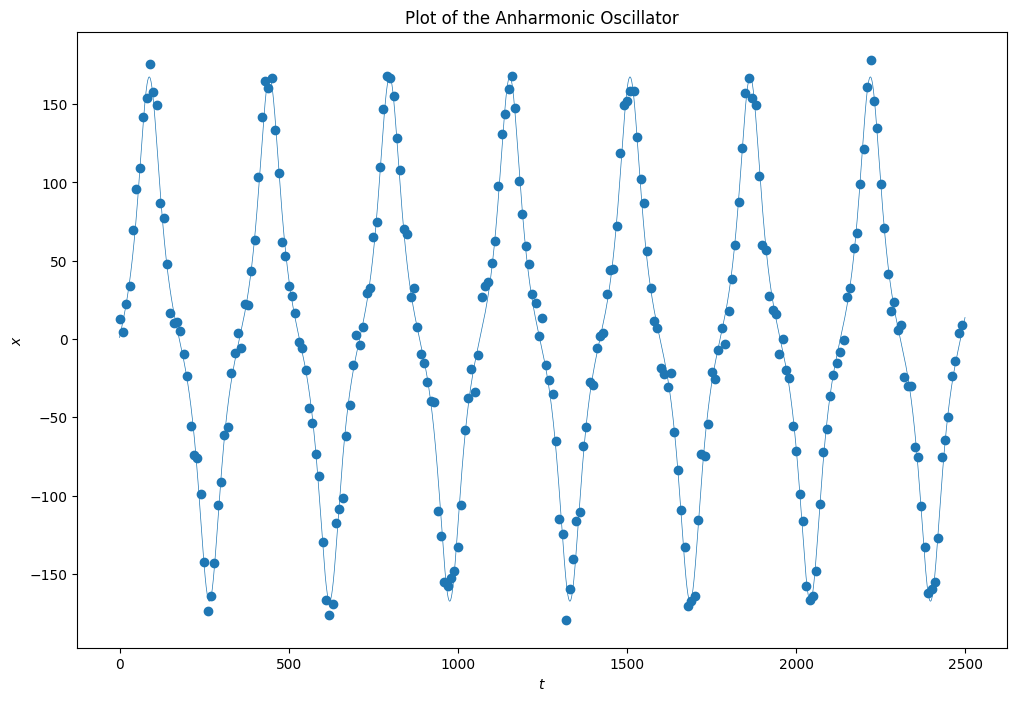

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import fractional_matrix_power

'''Discrete model approximating the anharmonic oscillator, this derivation comes from finite differencing of the continuous system'''
rng = np.random.default_rng()

sigma = 10 #standard deviation of the observation noise

x_0 = 0 
x_1 = 1

omega = 3.5 * 10**-2
lam = 3 * 10**-4

M = lambda u_k: np.array([
    [2 + omega**2 - lam**2 * u_k[0]**2, -1],
    [1,                               0]])

H = np.array([[1,0]])

N = 2500 #Number of time-points for which to simulate the system 

delta_t = 10

U = np.zeros((2,N)) #State is described by x_k and x_k-1
Y = np.zeros((1,N // delta_t)) #Observation is x_k 

R_o = sigma**2 * np.array([[1]]) #observation noise
t_dis = np.arange(0,N,delta_t)

U[0,0] = x_1
U[1,0] = x_0

y_index = 0
for k in range(0,N-1): 
   U[:,k+1] = M(U[:,k]) @ U[:,k]

   if(k % delta_t == 0): 
    Y[:,y_index] = H @ U[:,k]
    y_index += 1


Y = Y + rng.multivariate_normal([0],R_o,size = np.size(Y)).squeeze()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(U[0, :],linewidth = 0.5)
ax.scatter(t_dis,Y.squeeze())
ax.set_ylabel("$x$")
ax.set_xlabel("$t$")
ax.set_title("Plot of the Anharmonic Oscillator")
plt.show()

In [2]:
n_ens = 5
proc_noise = 0. * np.eye(2)

x0 = np.array([1,0])  # Initial state (equilibrium)

X_ens = rng.multivariate_normal(x0, np.eye(2), n_ens).T

m_post = np.zeros((2, len(t_dis)))

ones = np.ones((n_ens,1))

for i_time in range(0, len(t_dis)):

    #simulation
    if(i_time > 0):
        for i_ens in range(0, n_ens):
            for t in range(0,delta_t): 
                X_ens[:, i_ens] = M(X_ens[:, i_ens]) @ X_ens[:,i_ens]

    prior_mean = (1/n_ens) * X_ens @ ones @ ones.T
    
    prior_perturb = X_ens - prior_mean

    eigvals,eigvecs = np.linalg.eigh(np.eye(n_ens) + (1/(n_ens - 1)) * (H @ prior_perturb).T @ np.linalg.inv(R_o) @ H @ prior_perturb)

    Lam = eigvals * np.eye(n_ens)

    K = (1/(n_ens - 1)) * prior_perturb @ eigvecs @ np.linalg.inv(Lam) @ eigvecs.T @ (H @ X_ens).T @ np.linalg.inv(R_o) 

    post_mean = prior_mean + K @ (Y[:,i_time] @ ones.T - H @ prior_mean)

    post_perturb = prior_perturb @ eigvecs @ fractional_matrix_power(Lam,-0.5) @ eigvecs.T

    X_ens = post_mean + post_perturb

    m_post[:, i_time] = post_mean[:,0]

    m_post[:,i_time] = np.mean(X_ens,axis=1)
    

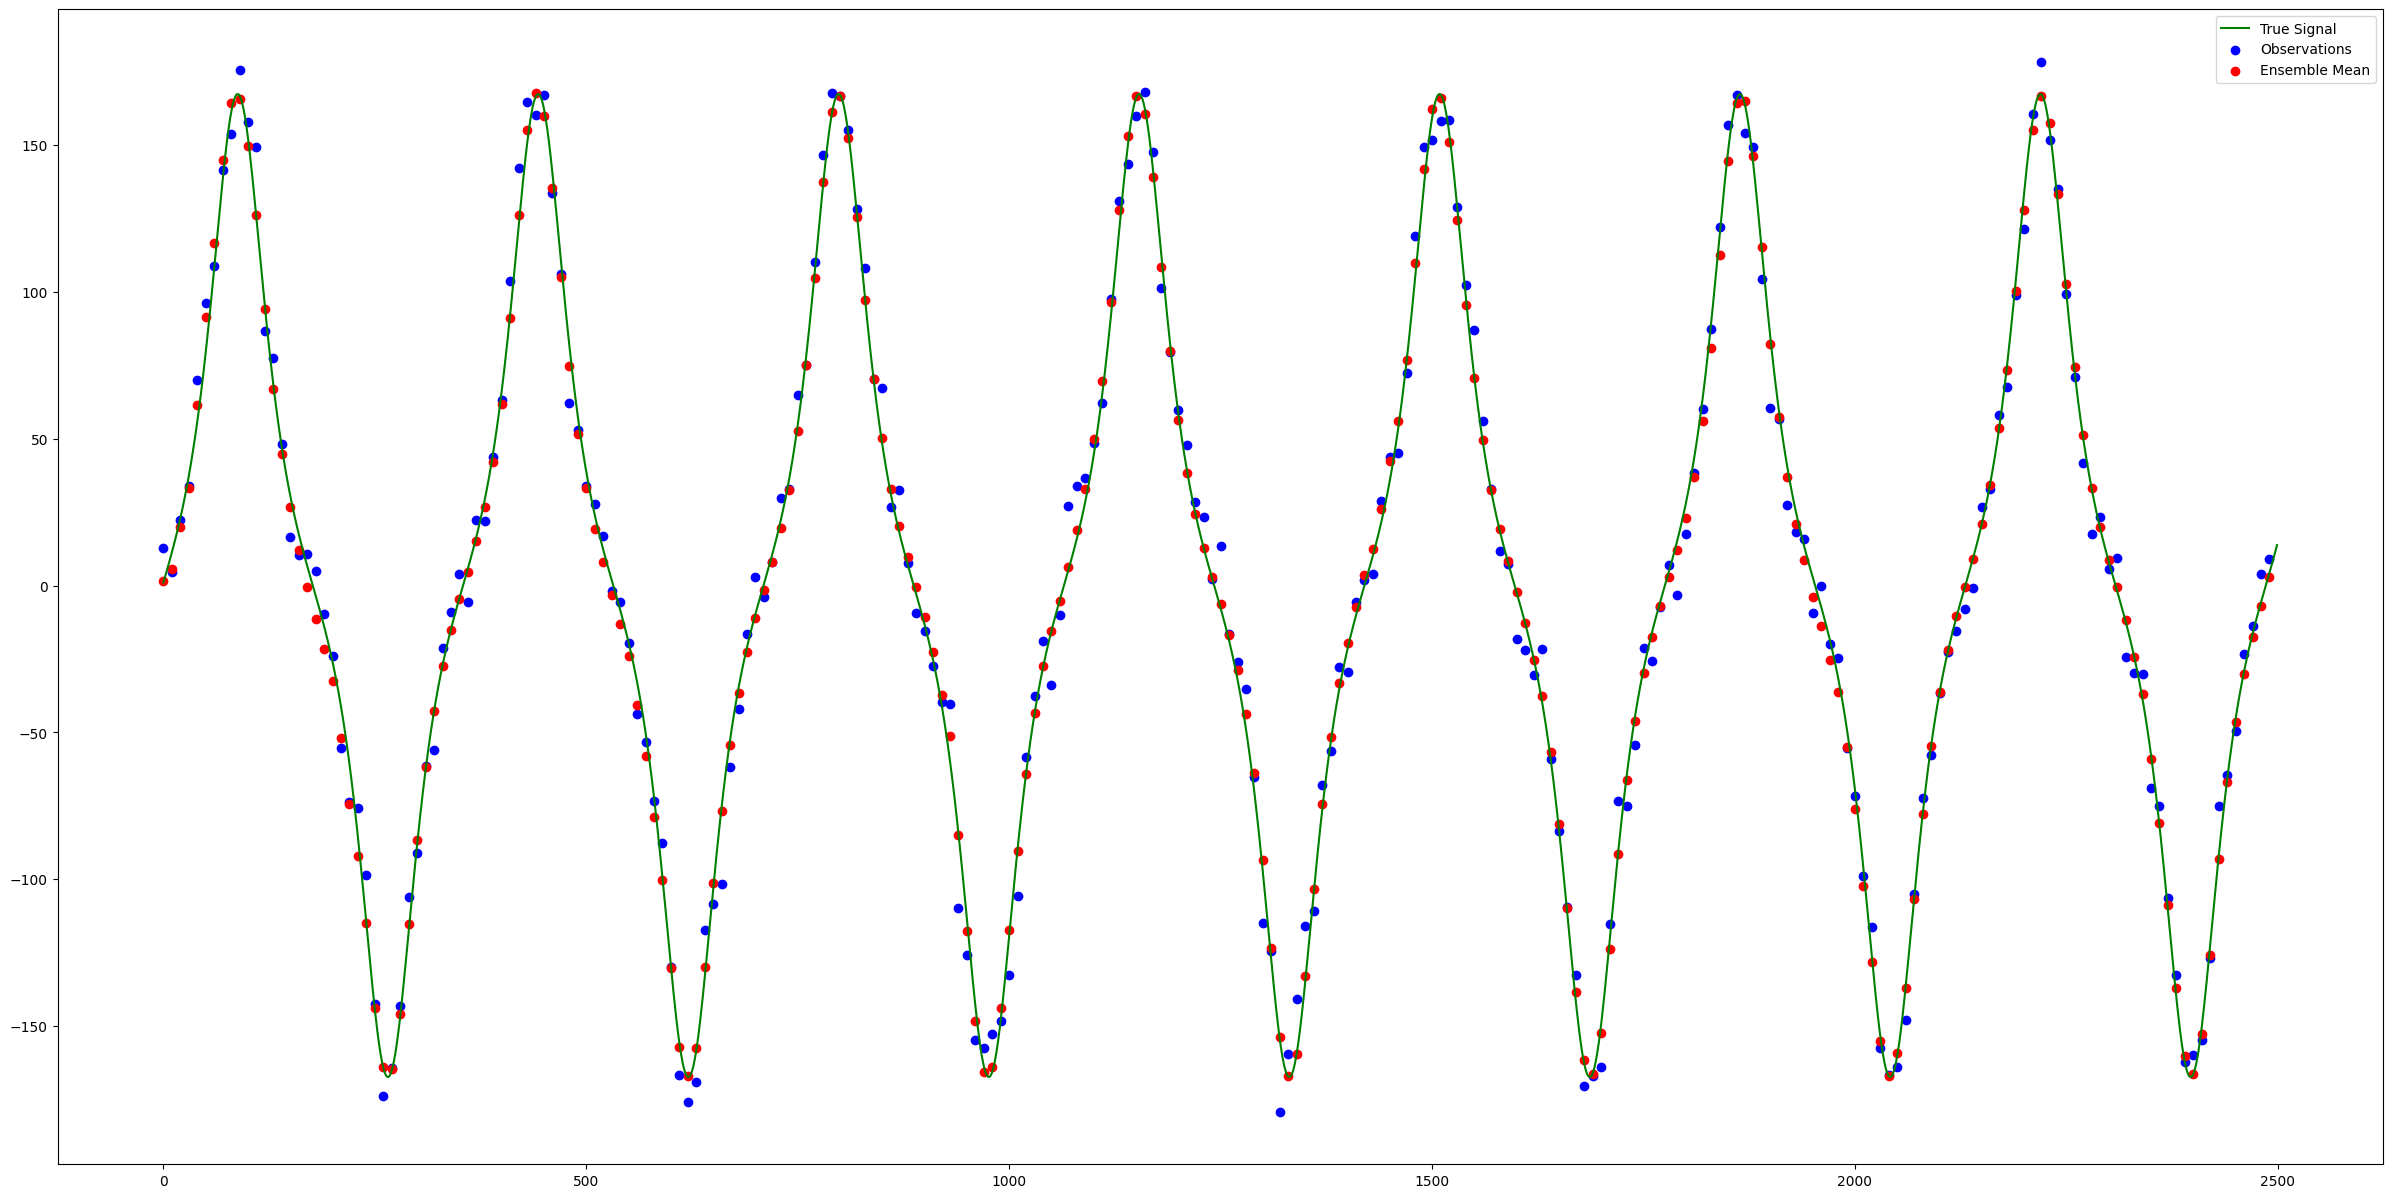

In [3]:
# Plot the first three variables
# The true signal is plotted in red
# The ensemble Kalman filter estimate is plotted in blue
fig = plt.figure(figsize=(30,15))

rows = 1
cols = 1

axes = fig.subplots(rows, cols)

axes.plot(U[0, :],color = 'green',label = 'True Signal')
axes.scatter(t_dis,Y.squeeze(),color = 'blue',label = 'Observations')
axes.scatter(t_dis,m_post[0,:],color = 'red',label = 'Ensemble Mean')
axes.legend()